In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('./garments_worker_productivity.csv')
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


### Columns description

- date : Date in MM-DD-YYYY
- day : Day of the Week
- quarter : A portion of the month. A month was divided into four quarters ( can be derived from date as well )
- department : Associated department with the instance
- teamno : Associated team number with the instance
- no_of_workers : Number of workers in each team, can be float (?)
- no_of_style_change : Number of changes in the style of a particular product
- targeted_productivity : Targeted productivity set by the Authority for each team for each day.  It ranges from 0-1.
- smv : Standard Minute Value, it is the allocated time for a task
- wip : Work in progress. Includes the number of unfinished items for products
- overtime : Represents the amount of overtime by each team in minutes
- incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
- idle_time : The amount of time when the production was interrupted due to several reasons
- idle_men : The number of workers who were idle due to production interruption
- actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

### Null value fix

(array([681.,   2.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,   4.]),
 array([7.00000e+00, 2.31850e+03, 4.63000e+03, 6.94150e+03, 9.25300e+03,
        1.15645e+04, 1.38760e+04, 1.61875e+04, 1.84990e+04, 2.08105e+04,
        2.31220e+04]),
 <BarContainer object of 10 artists>)

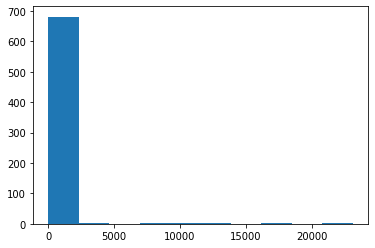

In [5]:
plt.hist(df['wip'])

0 is overwhelming majority in wip, so we replace null values with 0.

In [6]:
df['wip'].fillna(0, inplace=True)

### Data type fix

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   object        
 2   department             1197 non-null   object        
 3   day                    1197 non-null   object        
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    1197 non-null   float64       
 8   over_time              1197 non-null   int64         
 9   incentive              1197 non-null   int64         
 10  idle_time              1197 non-null   float64       
 11  idle_men               1197 non-null   int64         
 12  no_of_style_change     1197 non-null   int64         
 13  no_

### Categorical features

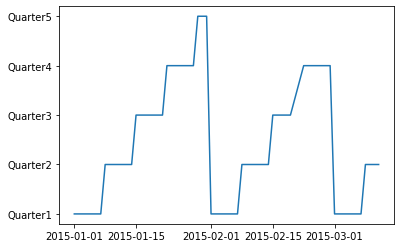

In [9]:
plt.plot(df['date'], df['quarter'])

All the data is from same year and only 3 different months, so we only extract the day of month as a numeric feature.

In [10]:
df['date'] = df['date'].dt.day

In [11]:
df['department'].value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

In [12]:
df['department'].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

'sweing' should be sewing, 'finishing ' should be 'finishing'

In [13]:
df['department'].replace('sweing', 'sewing', inplace=True)
df['department'].replace('finishing ', 'finishing', inplace=True)
df['department'].value_counts()

sewing       691
finishing    506
Name: department, dtype: int64

In [14]:
df['day'].value_counts()

Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: day, dtype: int64

Team is a categorical feature, so change its type to string

In [15]:
df['team'] = df['team'].astype(str)

### EDA

In [16]:
df.describe()

,date,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,13.533835,0.729632,15.062172,687.228070,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,8.623967,0.097891,10.943219,1514.582341,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,6.000000,0.700000,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,12.000000,0.750000,15.260000,586.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,21.000000,0.800000,24.260000,1083.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,31.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


actual_productivity max > 1, which violates the dataset description

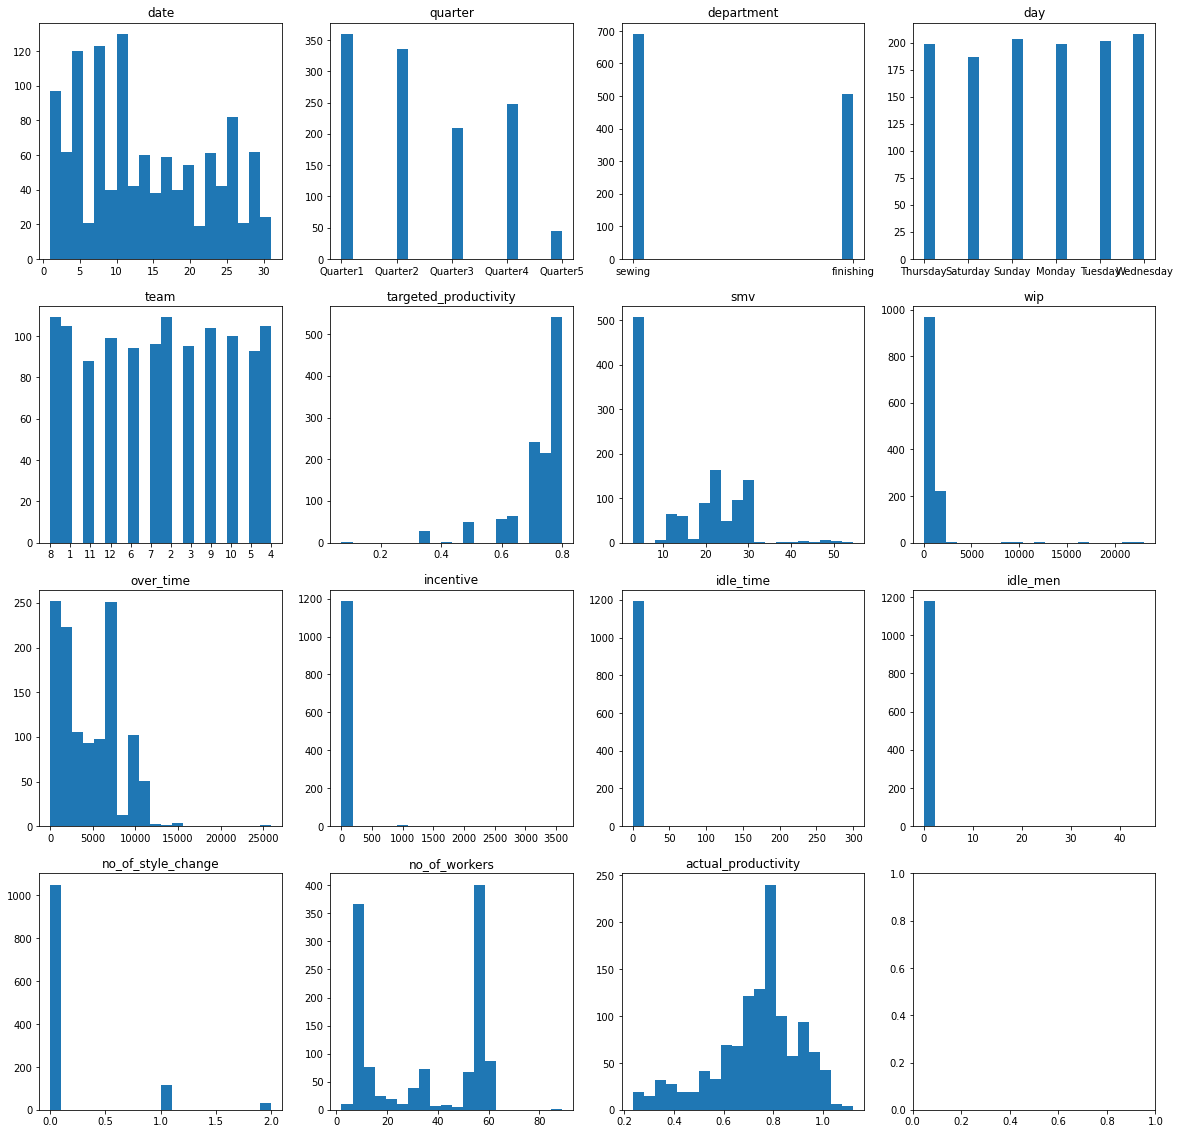

In [17]:
# subplot grid of 4 by 4
fig, ax = plt.subplots(4, 4, figsize=(20, 20))

# iterate through the subplots and plot the data

no_of_cols = len(df.columns)
col = 0

for i in range(4):
    for j in range(4):
        if col < no_of_cols :
            # histplot of col 
            ax[i, j].hist(df[df.columns[col]], bins=20)
            ax[i, j].set_title(df.columns[col])
            col += 1
        else:
            break



The plots of wip and incentives indicate that they have huge outliers. We can zoom on that using boxplot.

<AxesSubplot:xlabel='wip'>

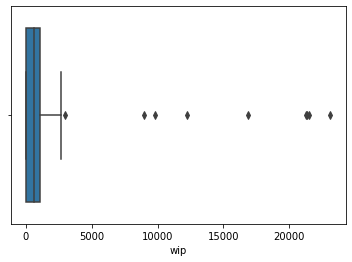

In [18]:
sns.boxplot(x='wip', data=df)

Number of outliers is fairly small, so we can discard them.

<AxesSubplot:xlabel='wip'>

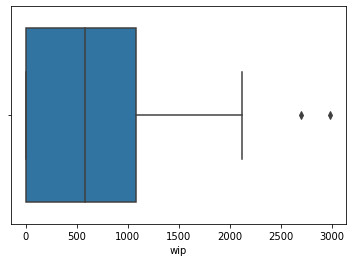

In [19]:
df = df[df['wip'] <= 5000]
sns.boxplot(x='wip', data=df)

<AxesSubplot:xlabel='incentive'>

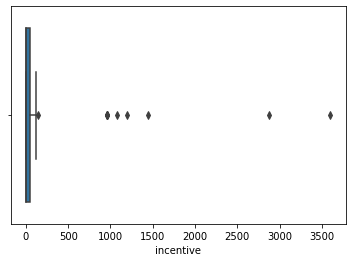

In [20]:
sns.boxplot(x='incentive', data=df)

Number of outliers is fairly small, so we can discard them.

<AxesSubplot:xlabel='incentive'>

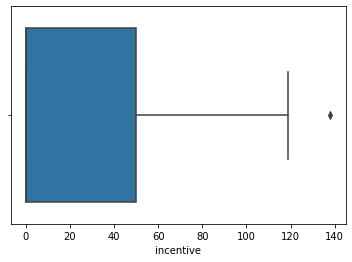

In [21]:
df = df[df['incentive'] <= 500]
sns.boxplot(x='incentive', data=df)

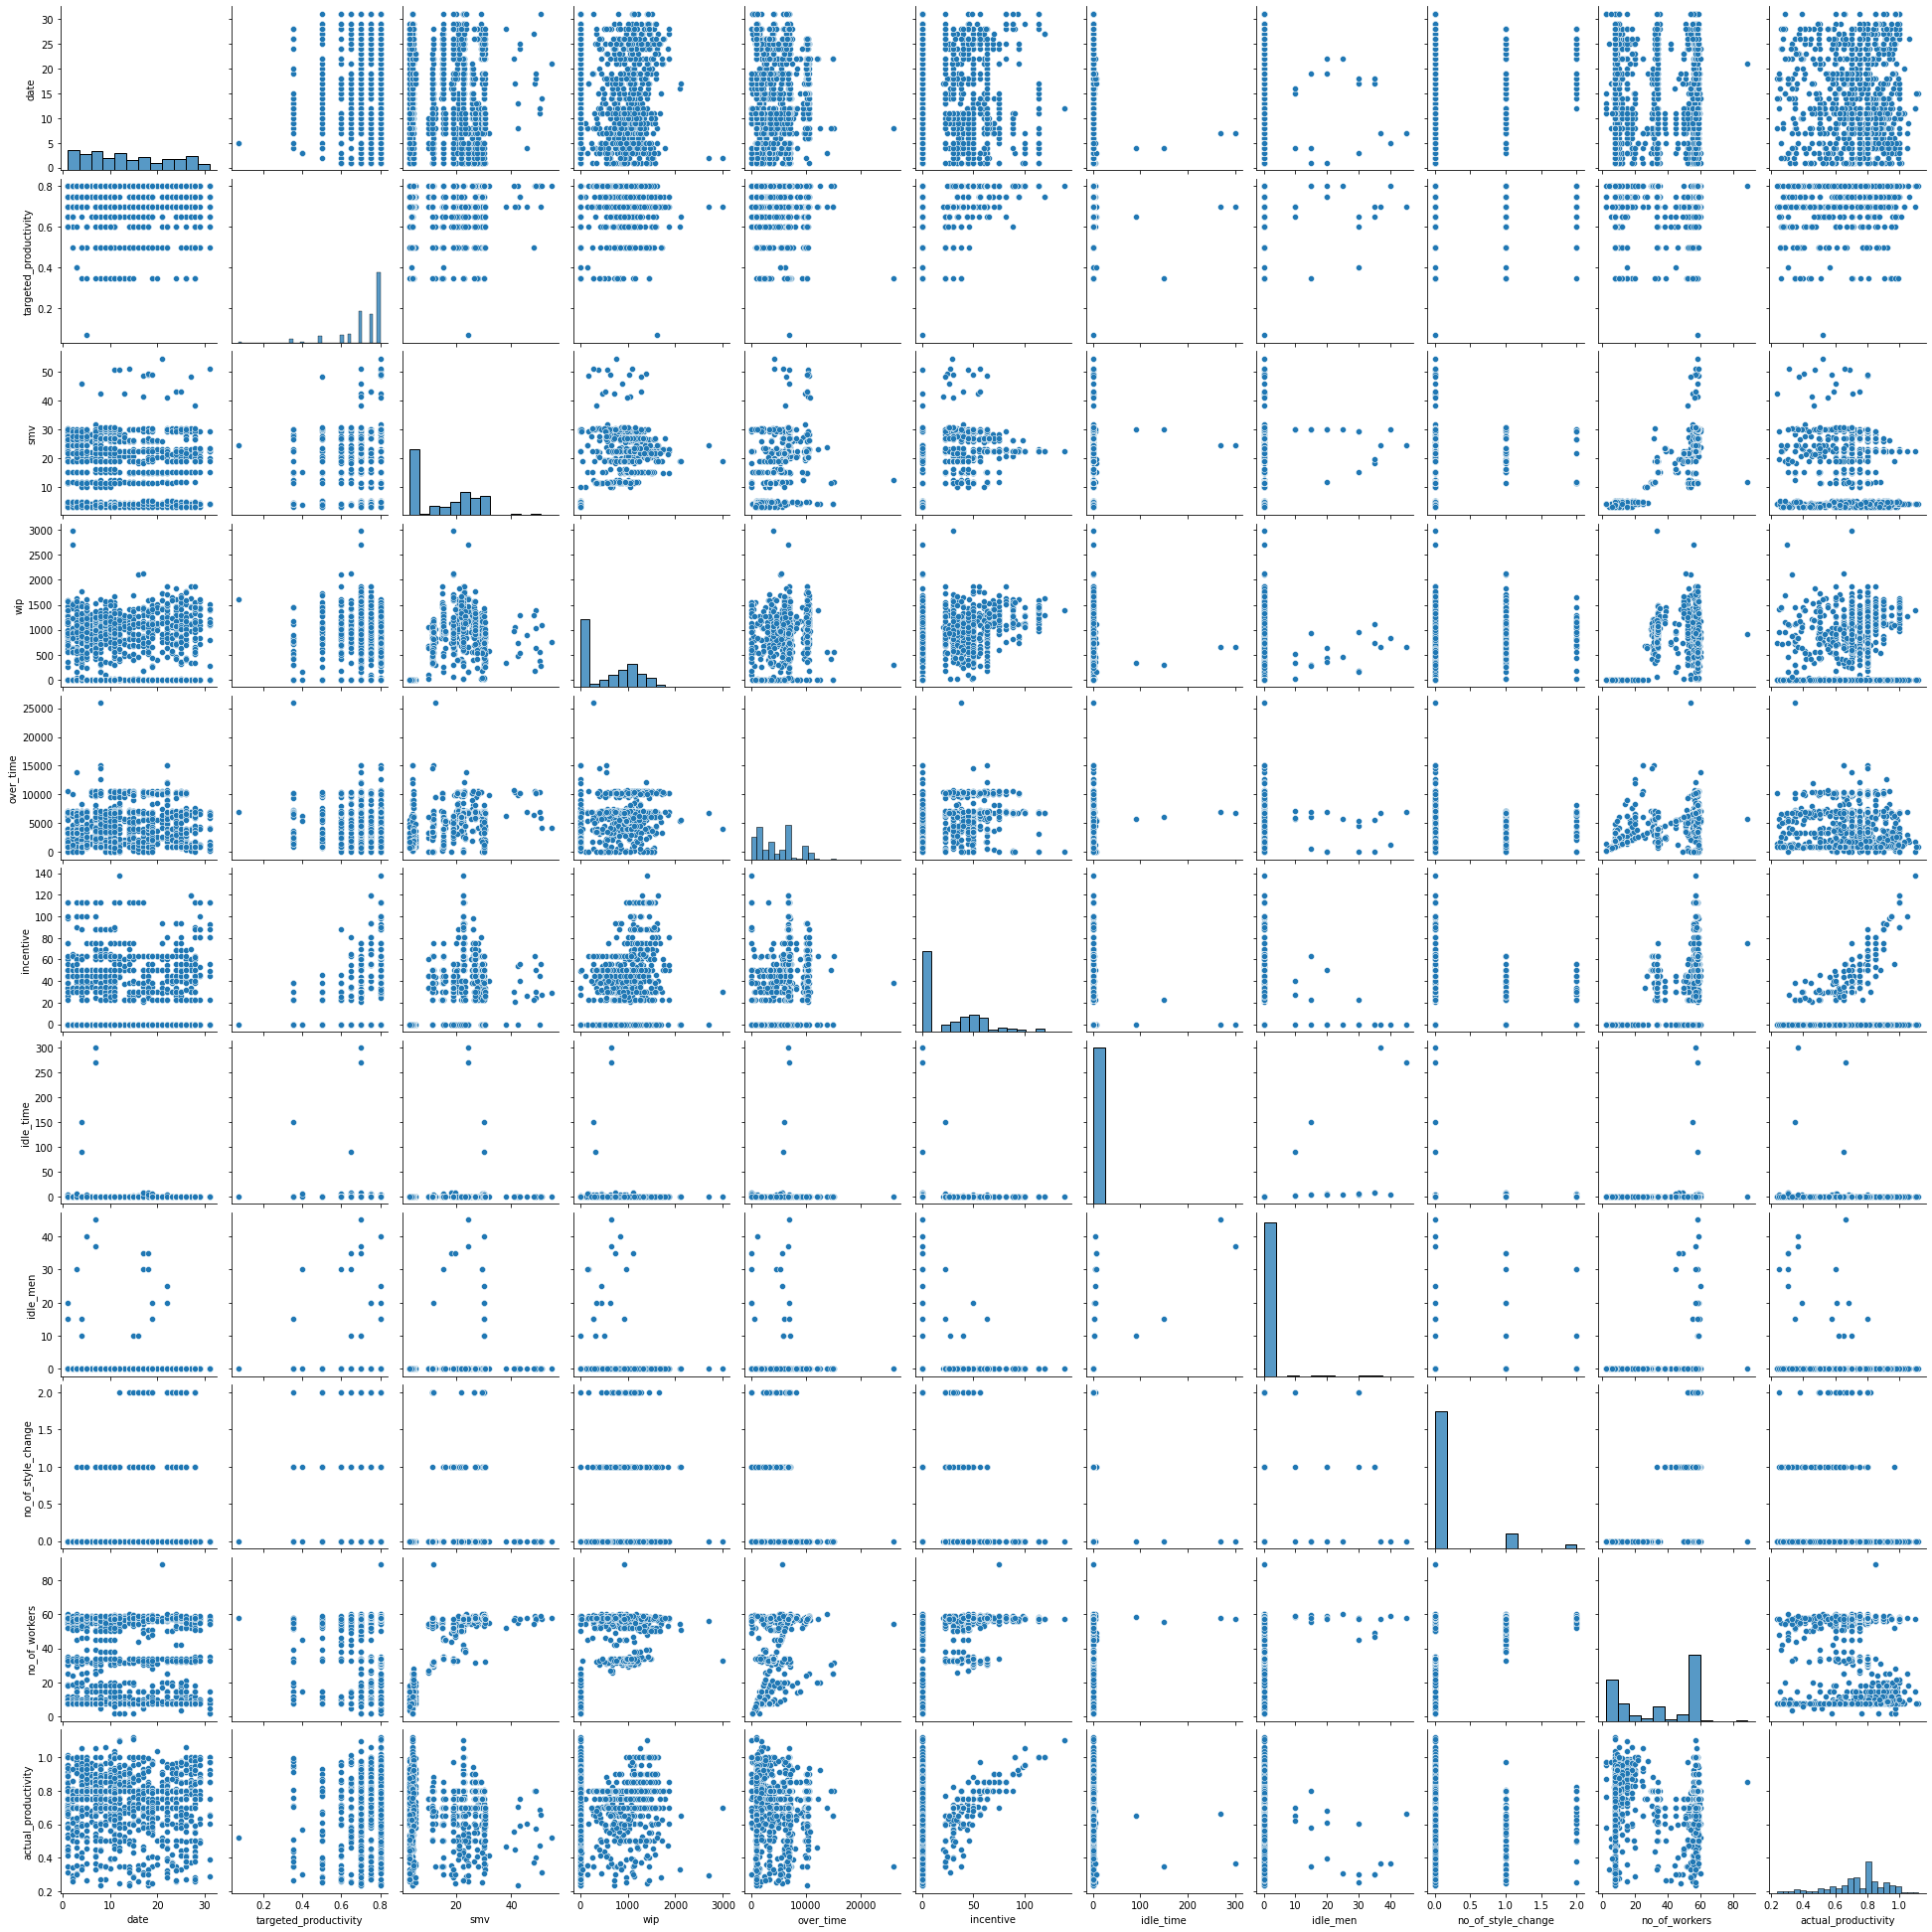

In [22]:
sns.pairplot(df)  # only uses numerical columns


The most prominent trend we can see here is between incentive and actual productivity, as expected XD. Target productivity also seems to be strongly correlated with actual productivity.

### correlation heatmap

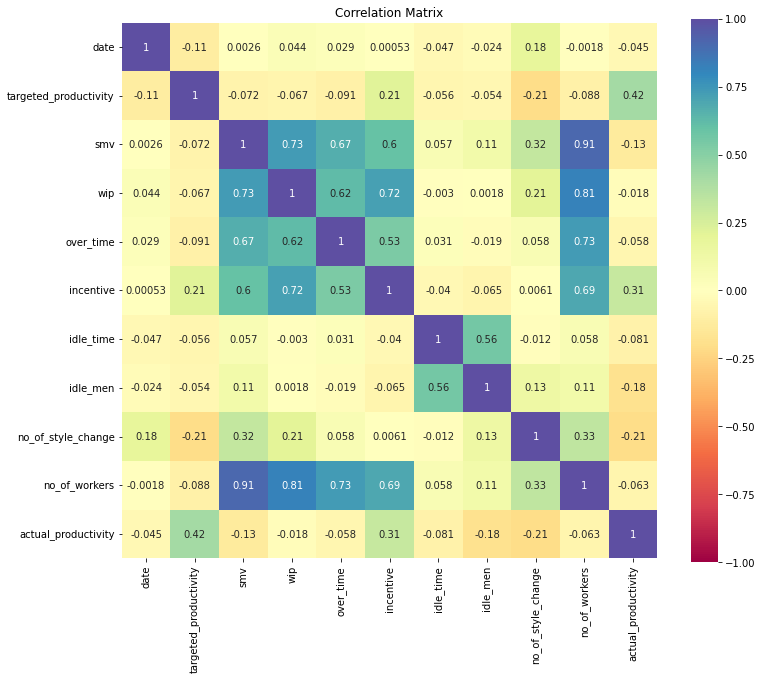

In [23]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='Spectral',
            square=True)

# add label to the plot 
plt.title('Correlation Matrix')
plt.show()



### Feature selection

In [24]:
df.columns

Index(['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity',
       'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers', 'actual_productivity'],
      dtype='object')

idle_men and idle_time features seem to be useless for predicting actual_productivity, almost all of their values are zero and the rest few doesn't seem to produce any pattern with the other features. So we discard them. We also drop date for now as it also shows no importance.

### Our target is to classify whether actual productivity reached the target productivity or not

Target productivity has 2 decimal digits. Productivity may fluctuate. It's better to be safe than sorry, so we check if the actual productivity misses target + 0.001

In [25]:
X = df.drop(columns=['actual_productivity', 'idle_time', 'idle_men', 'date'])
y = df['actual_productivity'] < df['targeted_productivity'] + 0.001

y.value_counts()

True     700
False    479
dtype: int64

Dataset is imbalanced. So we have to use stratify=y during split.

### Dataset split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train,
    random_state=0)  # 0.25 x 0.8 = 0.2


### Oversampling

We tried oversampling but it didn't improve the performance

In [27]:
# from imblearn.over_sampling import RandomOverSampler

# X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
# y_train.value_counts()

### One-hot encoding and Normalization

In [28]:
categorical_features = ['quarter', 'department', 'day', 'team']
transformer = make_column_transformer(
    (preprocessing.OneHotEncoder(), categorical_features),
    (preprocessing.StandardScaler(), [
        'smv', 'wip', 'over_time', 'incentive', 'no_of_style_change',
        'no_of_workers'
    ]),
    remainder='passthrough',
    sparse_threshold=0,
    verbose_feature_names_out=False)
transformer.fit(X_train)

X_train = pd.DataFrame(transformer.transform(X_train),
                       index=X_train.index,
                       columns=transformer.get_feature_names_out())
X_val = pd.DataFrame(transformer.transform(X_val),
                     index=X_val.index,
                     columns=transformer.get_feature_names_out())
X_test = pd.DataFrame(transformer.transform(X_test),
                      index=X_test.index,
                      columns=transformer.get_feature_names_out())

X_test

,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,department_finishing,department_sewing,day_Monday,day_Saturday,day_Sunday,...,team_7,team_8,team_9,smv,wip,over_time,incentive,no_of_style_change,no_of_workers,targeted_productivity
556,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.491114,1.083047,0.498349,1.657714,-0.346991,0.897846,0.70
689,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.408707,0.478655,0.756926,-0.805859,2.131013,1.076858,0.35
700,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.046998,0.578812,-0.129624,0.836523,-0.346991,0.002785,0.80
310,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.713171,0.989798,1.745059,0.343808,-0.346991,1.009729,0.65
972,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.344476,0.392314,0.018135,1.033609,4.609016,1.076858,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.168298,-0.041122,0.756926,-0.017516,2.131013,1.076858,0.70
1167,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.124076,0.677241,0.276711,0.508047,2.131013,0.495069,0.70
544,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.751710,1.756512,-0.443610,2.905925,-0.346991,1.099235,0.80
286,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.023318,1.255730,1.745059,0.836523,-0.346991,1.009729,0.80


### Model evaluation

In [29]:
from sklearn.metrics import *


def get_perf_metrics(model):
    model_name = type(model).__name__
    print(f"Training {model_name} model...")
    model.fit(X_train, y_train)
    print(f"Completed {model_name} model training.")
    y_pred = model.predict(X_val)

    df_perf_metrics = pd.DataFrame(columns=[
        'Training_Accuracy', 'Validation: Accuracy', 'Precision', 'Recall',
        'f1_weighted'
    ])

    df_perf_metrics.loc[model_name] = [
        model.score(X_train, y_train),
        model.score(X_val, y_val),
        precision_score(y_val, y_pred),
        recall_score(y_val, y_pred),
        f1_score(y_val, y_pred, average='weighted'),
    ]

    print("Completed {} model's performance assessment.".format(model_name))
    return df_perf_metrics

### Base model selection

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

models_list = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0),
    AdaBoostClassifier(random_state=0)
]

df_perf_metrics = pd.concat([get_perf_metrics(model) for model in models_list],
                            axis=0)

df_perf_metrics

Training LogisticRegression model...
Completed LogisticRegression model training.
Completed LogisticRegression model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Completed RandomForestClassifier model's performance assessment.
Training AdaBoostClassifier model...
Completed AdaBoostClassifier model training.
Completed AdaBoostClassifier model's performance assessment.


,Training_Accuracy,Validation: Accuracy,Precision,Recall,f1_weighted
LogisticRegression,0.787836,0.800847,0.825175,0.842857,0.800322
RandomForestClassifier,1.000000,0.894068,0.932331,0.885714,0.894573
AdaBoostClassifier,0.855728,0.860169,0.890511,0.871429,0.860488


### Hyperparameter tuning

#### Tuning n_estimators & max_depth

In [33]:
rfc = RandomForestClassifier(random_state=0)
parameters = {"n_estimators": [64, 128, 256], "max_depth": [4, 8, 16, None]}

from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(rfc, parameters, cv=5, scoring='f1_weighted')
cv.fit(X_train, y_train.values.ravel())


def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean, std, params in zip(mean_score, std_score, params):
        print(f'{round(mean,3)} +-{round(std,3)} for {params}')


display(cv)

Best parameters are: {'max_depth': 8, 'n_estimators': 128}


0.785 +-0.035 for {'max_depth': 4, 'n_estimators': 64}
0.783 +-0.037 for {'max_depth': 4, 'n_estimators': 128}
0.788 +-0.039 for {'max_depth': 4, 'n_estimators': 256}
0.816 +-0.035 for {'max_depth': 8, 'n_estimators': 64}
0.825 +-0.036 for {'max_depth': 8, 'n_estimators': 128}
0.825 +-0.036 for {'max_depth': 8, 'n_estimators': 256}
0.819 +-0.032 for {'max_depth': 16, 'n_estimators': 64}
0.822 +-0.037 for {'max_depth': 16, 'n_estimators': 128}
0.821 +-0.031 for {'max_depth': 16, 'n_estimators': 256}
0.824 +-0.036 for {'max_depth': None, 'n_estimators': 64}
0.815 +-0.039 for {'max_depth': None, 'n_estimators': 128}
0.821 +-0.037 for {'max_depth': None, 'n_estimators': 256}


#### Tuning min_impurity_decrease

In [ ]:
rfc = RandomForestClassifier(max_depth=8, n_estimators=128,
                               random_state=0)
parameters = {"min_impurity_decrease": [0, 0.001, 0.01, 0.1]}

from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(rfc, parameters, cv=5, scoring='f1_weighted')
cv.fit(X_train, y_train.values.ravel())


def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean, std, params in zip(mean_score, std_score, params):
        print(f'{round(mean,3)} +-{round(std,3)} for {params}')


display(cv)

Best parameters are: {'min_impurity_decrease': 0}


0.825 +-0.036 for {'min_impurity_decrease': 0}
0.813 +-0.041 for {'min_impurity_decrease': 0.001}
0.785 +-0.04 for {'min_impurity_decrease': 0.01}
0.443 +-0.002 for {'min_impurity_decrease': 0.1}


#### Tuning ccp_alpha

In [33]:
rfc = RandomForestClassifier(max_depth=8, n_estimators=128,
                               random_state=0)
parameters = {"ccp_alpha": [0, 0.001, 0.01, 0.1]}

from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(rfc, parameters, cv=5, scoring='f1_weighted')
cv.fit(X_train, y_train.values.ravel())


def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean, std, params in zip(mean_score, std_score, params):
        print(f'{round(mean,3)} +-{round(std,3)} for {params}')


display(cv)

Best parameters are: {'ccp_alpha': 0}


0.825 +-0.036 for {'ccp_alpha': 0}
0.823 +-0.036 for {'ccp_alpha': 0.001}
0.793 +-0.037 for {'ccp_alpha': 0.01}
0.443 +-0.002 for {'ccp_alpha': 0.1}


### Test results of the best model

In [34]:
model = RandomForestClassifier(max_depth=8, n_estimators=128,
                               random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.84      0.84        96
        True       0.89      0.89      0.89       140

    accuracy                           0.87       236
   macro avg       0.87      0.87      0.87       236
weighted avg       0.87      0.87      0.87       236



### Error analysis using DecisionTreeClassifier

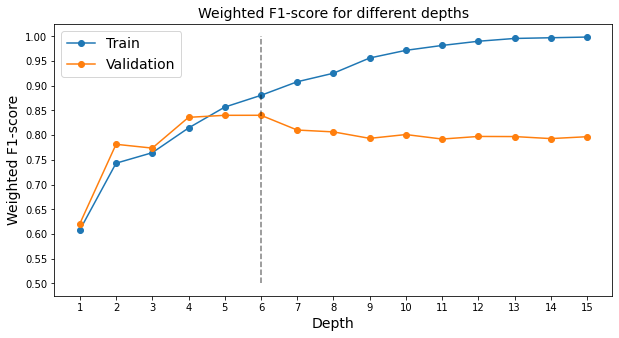

0.8402967089407767
[0.6208943790098631, 0.7815797889350816, 0.7738638252325766, 0.8361257124074137, 0.8402172124403487, 0.8402967089407767, 0.8104247042976374, 0.8066749634546245, 0.7935735669018718, 0.8013009568905061, 0.7921987981389438, 0.7974649376356664, 0.7972117365737748, 0.7931202240072583, 0.7969269525843591]


In [35]:
train_scores = []
val_scores = []
for i in range(1, 16, 1):
    model = DecisionTreeClassifier(max_depth=i,
                                   random_state=0).fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    train_scores.append(f1_score(y_train, y_pred_train, average='weighted'))

    y_pred = model.predict(X_val)
    val_scores.append(f1_score(y_val, y_pred, average='weighted'))

best_val = np.argmax(val_scores) + 1

# Plot of depth vs accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 16, 1), train_scores, marker='o', label='Train')
plt.plot(np.arange(1, 16, 1), val_scores, marker='o', label="Validation")
plt.plot([best_val, best_val], [0.5, 1.0], '--', color='black', alpha=0.5)
plt.xlabel("Depth", fontsize=14)
plt.ylabel("Weighted F1-score", fontsize=14)
plt.title("Weighted F1-score for different depths", fontsize=14)
plt.xticks(np.arange(1, 16, 1))
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.legend(fontsize=14)
plt.show()
print(np.max(val_scores))
print(val_scores)

[Text(0.5532407407407407, 0.9285714285714286, 'incentive <= 1.296\ngini = 0.482\nsamples = 707\nvalue = [287, 420]'),
 Text(0.5347222222222222, 0.7857142857142857, 'department_sewing <= 0.5\ngini = 0.456\nsamples = 647\nvalue = [227, 420]'),
 Text(0.2824074074074074, 0.6428571428571429, 'no_of_workers <= -1.138\ngini = 0.49\nsamples = 310\nvalue = [177, 133]'),
 Text(0.14814814814814814, 0.5, 'smv <= -0.994\ngini = 0.491\nsamples = 176\nvalue = [76, 100]'),
 Text(0.07407407407407407, 0.35714285714285715, 'targeted_productivity <= 0.625\ngini = 0.334\nsamples = 66\nvalue = [14, 52]'),
 Text(0.037037037037037035, 0.21428571428571427, 'day_Sunday <= 0.5\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(0.018518518518518517, 0.07142857142857142, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.05555555555555555, 0.07142857142857142, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.1111111111111111, 0.21428571428571427, 'team_6 <= 0.5\ngini = 0.259\nsamples = 59\nvalue = [9, 50]'),


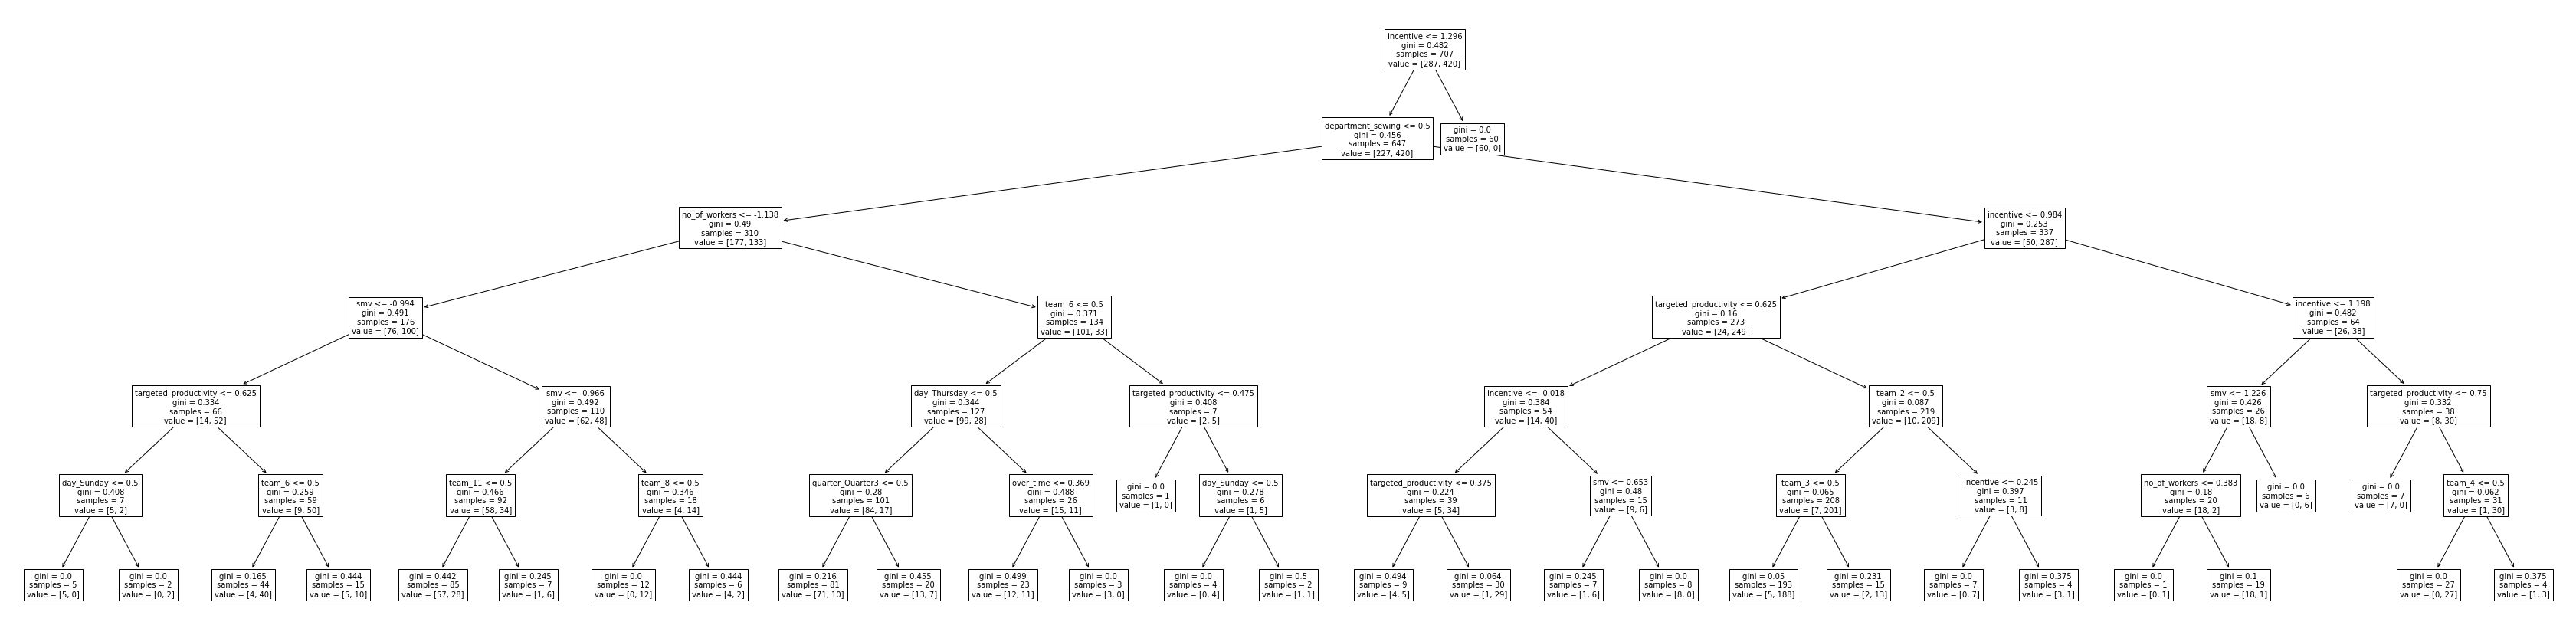

In [36]:
from sklearn.tree import plot_tree

plt.figure(figsize=(60, 15))
model = DecisionTreeClassifier(max_depth=6).fit(X_train, y_train)
plot_tree(model, fontsize=10, feature_names=X_train.columns)

In [37]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.76      0.89      0.82        96
        True       0.91      0.81      0.86       140

    accuracy                           0.84       236
   macro avg       0.84      0.85      0.84       236
weighted avg       0.85      0.84      0.84       236



#### Misclassified samples

In [38]:
misclassified_samples = (y_val != y_pred)
df_mis = df.loc[y_val[misclassified_samples].index]
df_mis

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
976,28,Quarter4,finishing,Saturday,12,0.80,4.60,0.0,3780,0,0.0,0,0,9.0,0.590617
52,4,Quarter1,finishing,Sunday,2,0.80,3.94,0.0,960,0,0.0,0,0,8.0,0.792104
739,12,Quarter2,finishing,Thursday,9,0.80,3.94,0.0,960,0,0.0,0,0,8.0,0.656667
384,22,Quarter4,finishing,Thursday,2,0.70,3.94,0.0,15000,0,0.0,0,0,25.0,0.649662
382,22,Quarter4,finishing,Thursday,4,0.75,4.30,0.0,9000,0,0.0,0,0,15.0,0.670216
781,15,Quarter3,sewing,Sunday,3,0.60,30.10,1361.0,6960,30,0.0,0,1,58.0,0.475718
294,17,Quarter3,sewing,Saturday,3,0.60,22.52,1140.0,10170,30,0.0,0,0,56.5,0.600292
239,14,Quarter2,finishing,Wednesday,4,0.35,4.30,0.0,2700,0,0.0,0,0,8.0,0.908081
497,28,Quarter4,finishing,Wednesday,11,0.50,2.90,0.0,960,0,0.0,0,0,8.0,0.259375
592,3,Quarter1,sewing,Tuesday,11,0.70,25.31,946.0,5760,60,0.0,0,0,54.0,0.700514


In [39]:
(df_mis['actual_productivity'] <
 df_mis['targeted_productivity']).value_counts()


True     24
False    14
dtype: int64

#### Compare misclassified samples to the whole validation set

In [40]:
df_val = df.loc[X_val.index]
len(df_val) / len(df_mis)


6.2105263157894735

<AxesSubplot:ylabel='Count'>

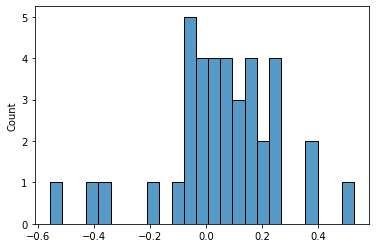

In [41]:
sns.histplot(df_mis['targeted_productivity'] - df_mis['actual_productivity'],
             bins=25)


<AxesSubplot:ylabel='Count'>

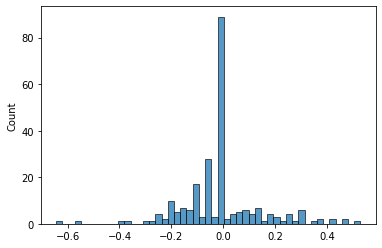

In [42]:
sns.histplot(df_val['targeted_productivity'] - df_val['actual_productivity'])


It seems that the model performs quite poorly when target is missed by comparitively huge margin. Maybe these cases are caused by other factors like fatigue.

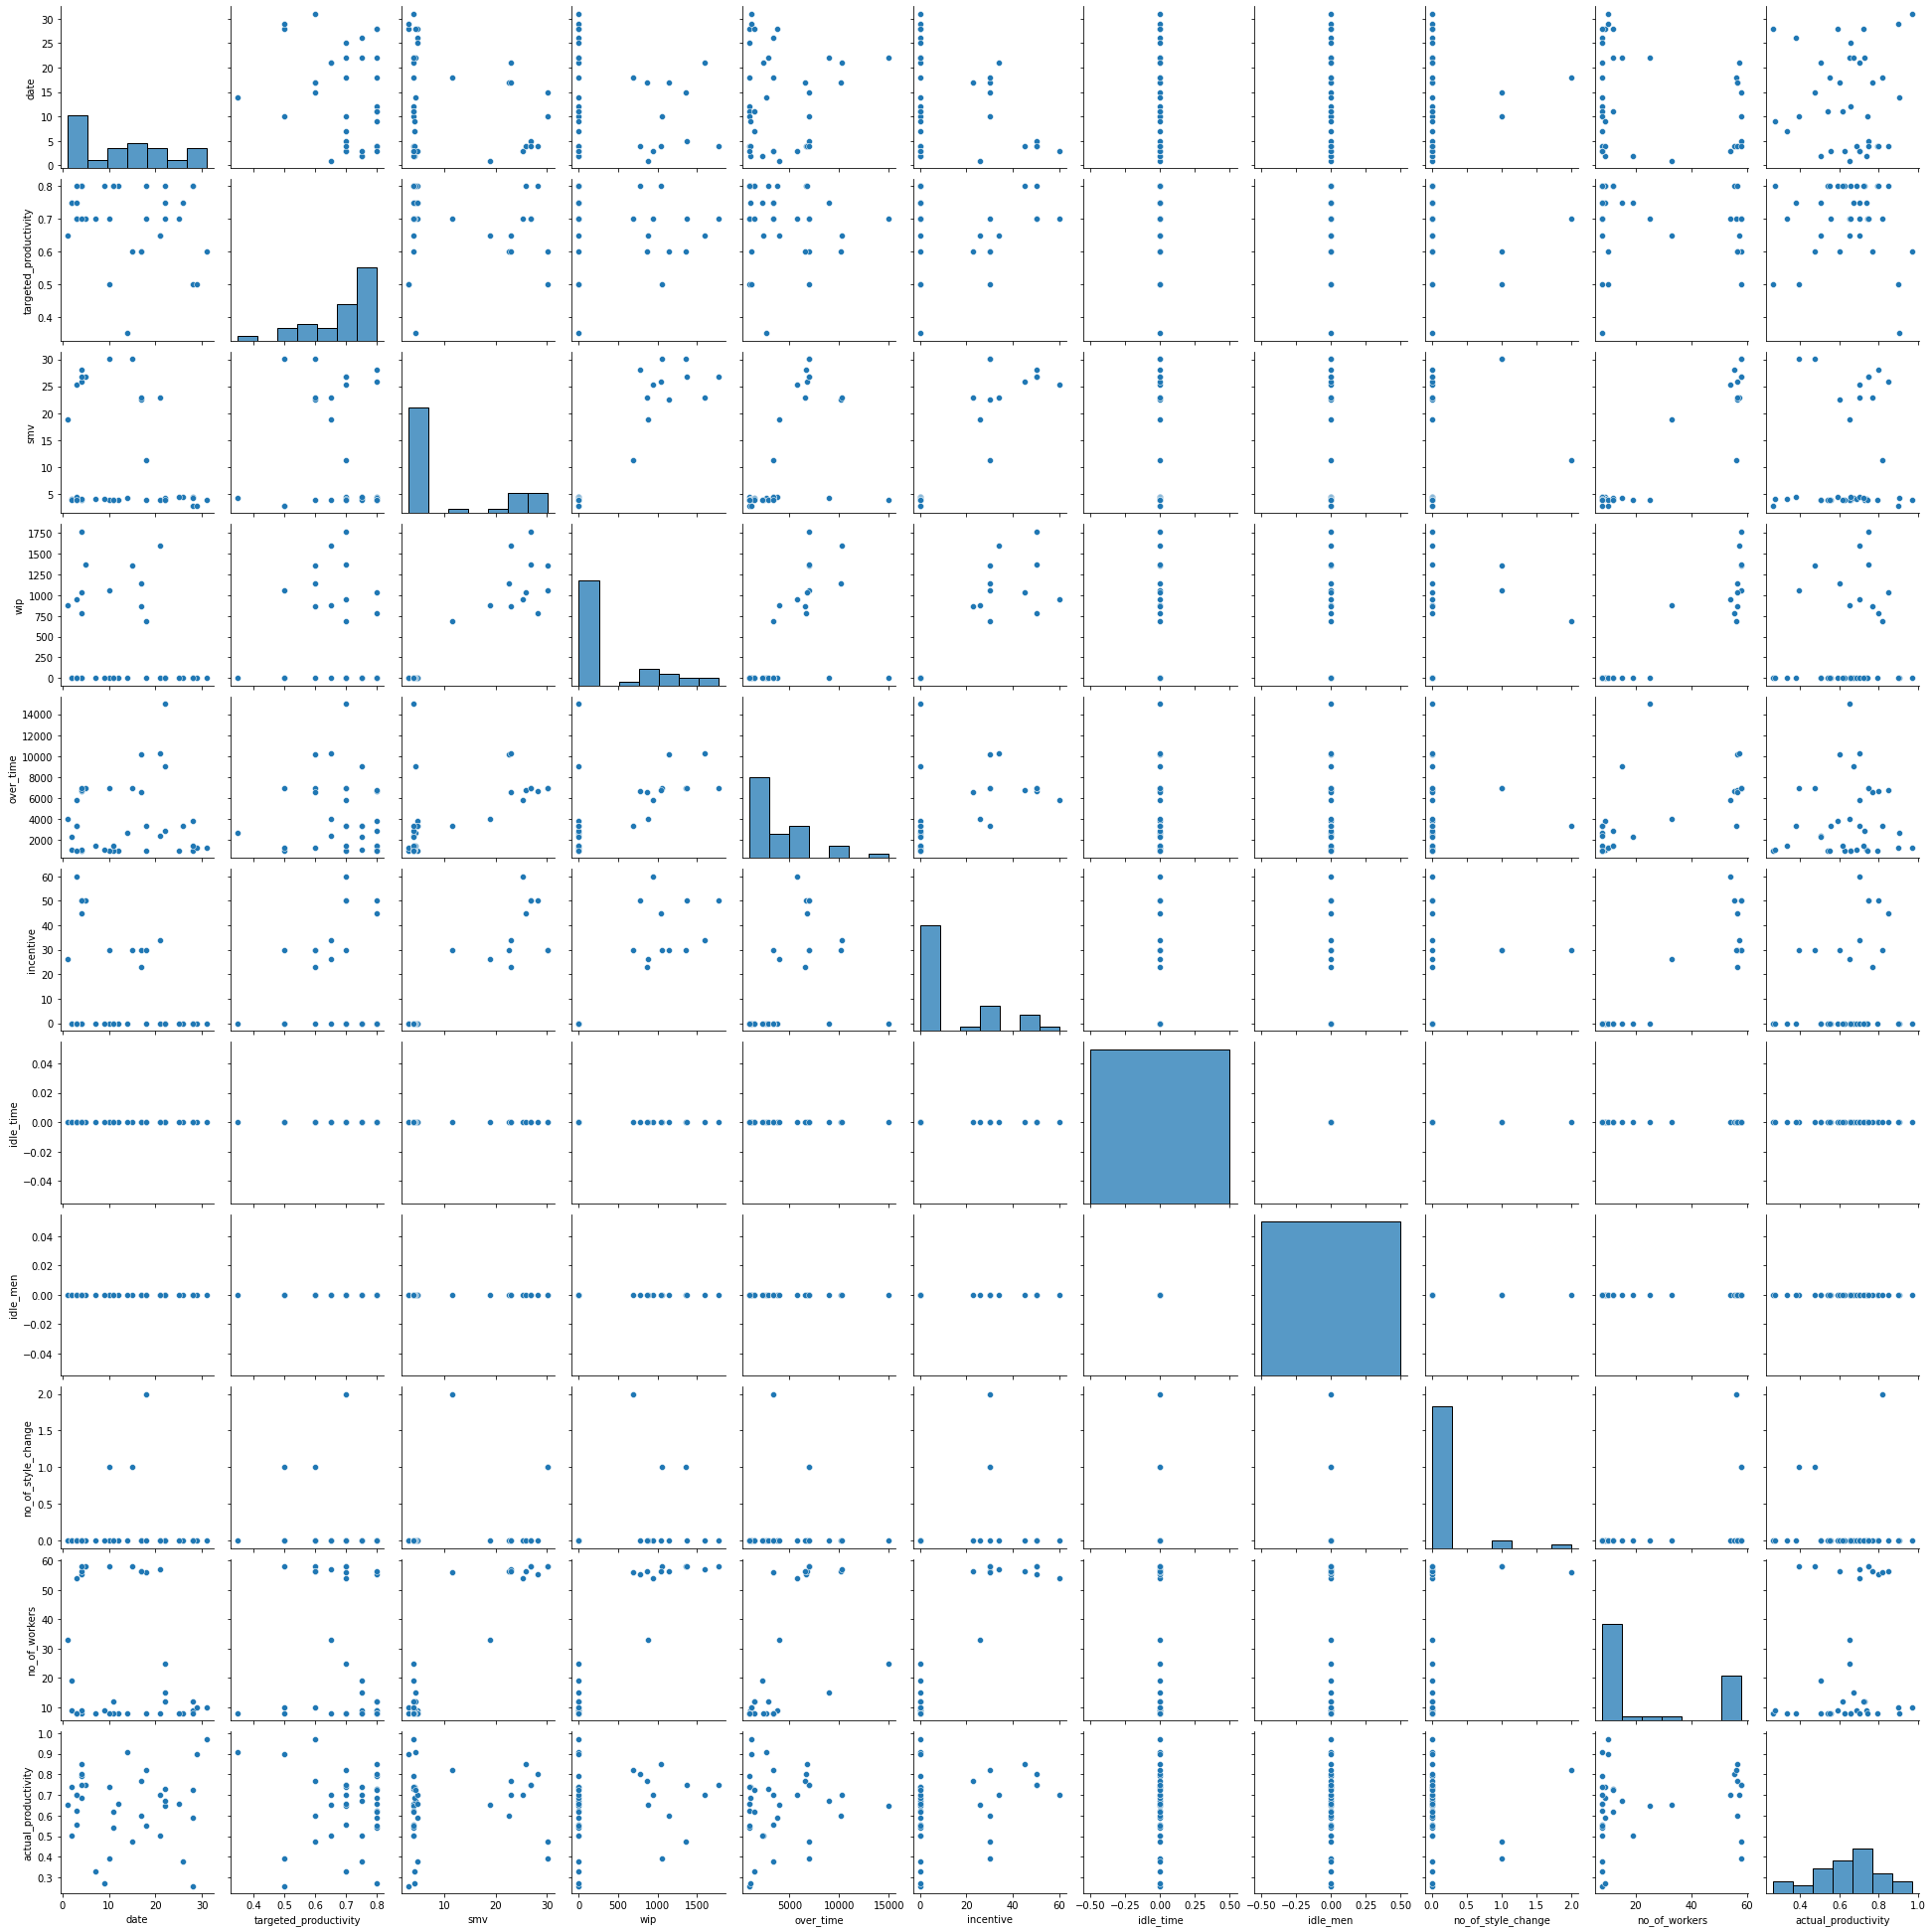

In [43]:
sns.pairplot(df_mis)

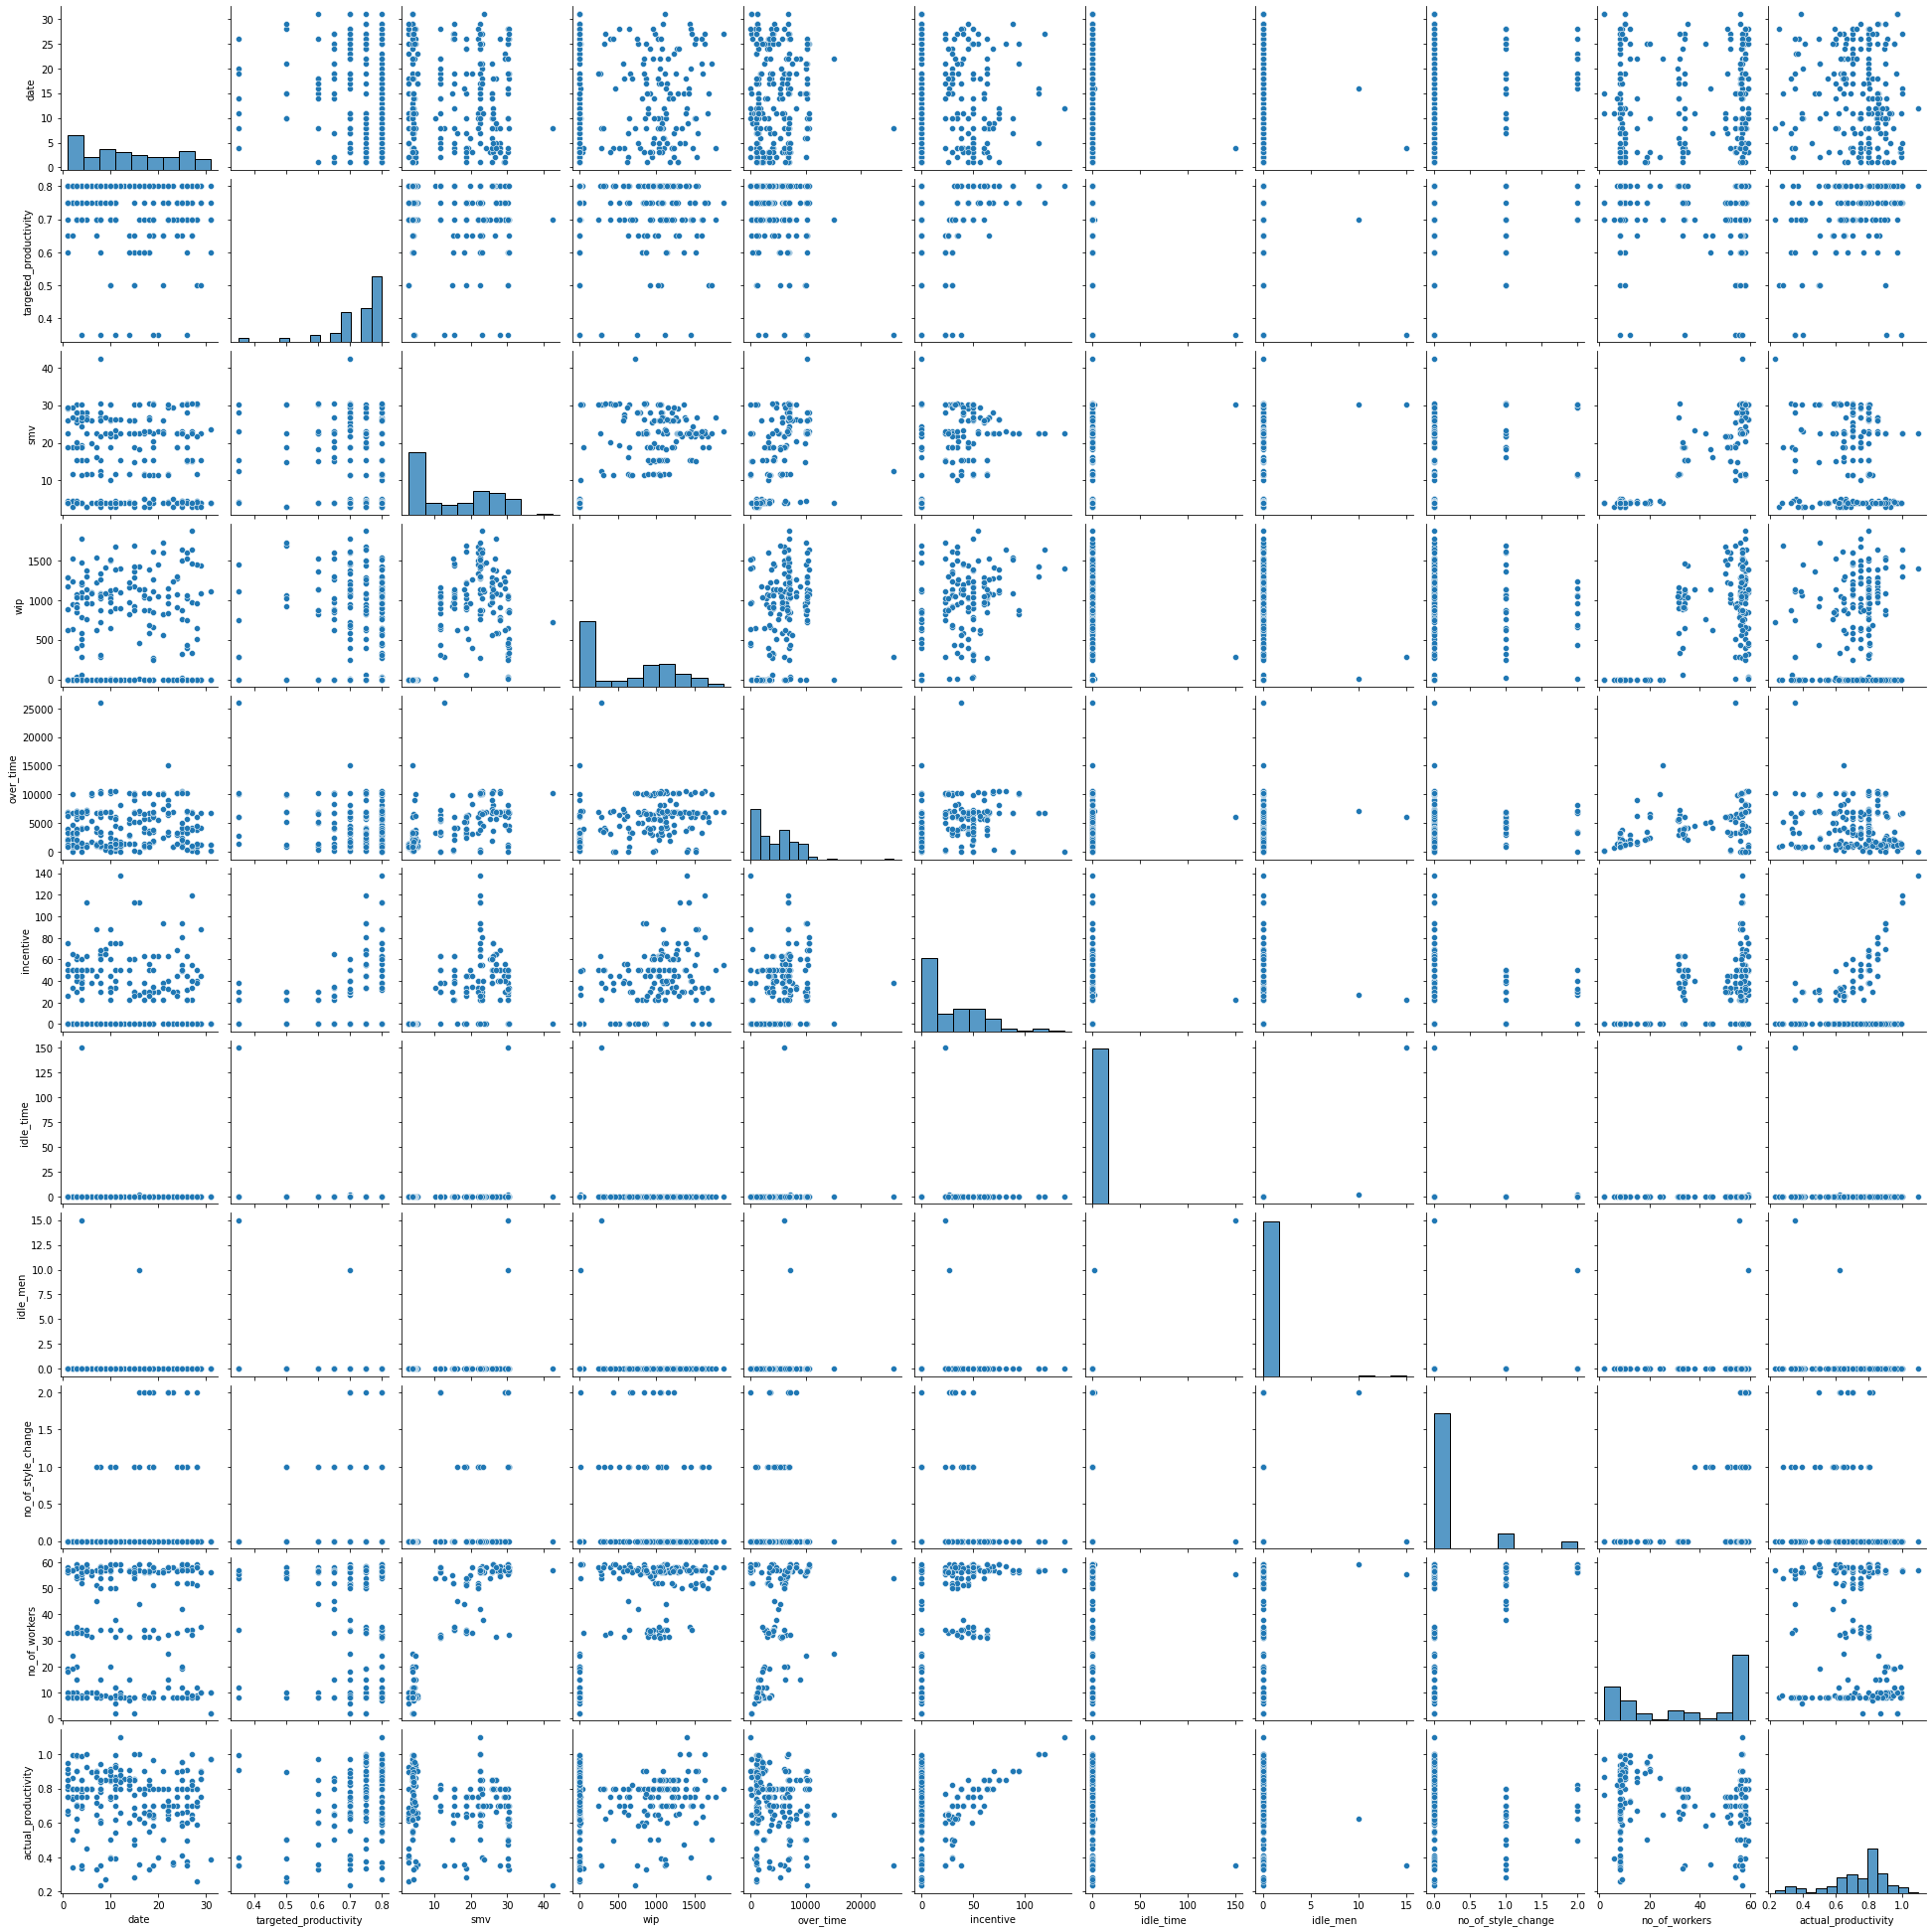

In [44]:
sns.pairplot(df_val)

## error analysis

Text(0, 0.5, 'Frequency')

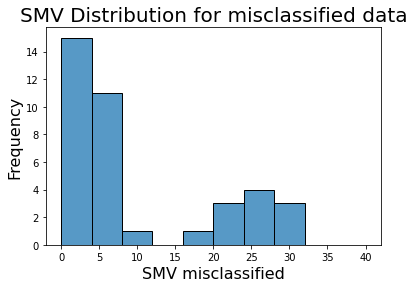

In [58]:
sns.histplot(df_mis['smv'], bins=10, binrange=(0, 40))

plt.title('SMV Distribution for misclassified data', fontsize=20)
plt.xlabel('SMV misclassified', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

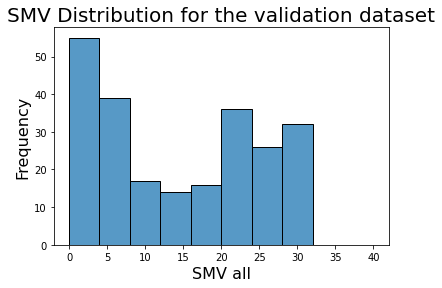

In [66]:
sns.histplot(df_val['smv'], bins=10, binrange=(0, 40))

# add a title to the plot
plt.title('SMV Distribution for the validation dataset', fontsize=20)
plt.xlabel('SMV all', fontsize=16)
plt.ylabel('Frequency', fontsize=16)


Maybe anomalous productivity is related with extreme (too small or too large) deadlines.

Text(0, 0.5, 'Frequency')

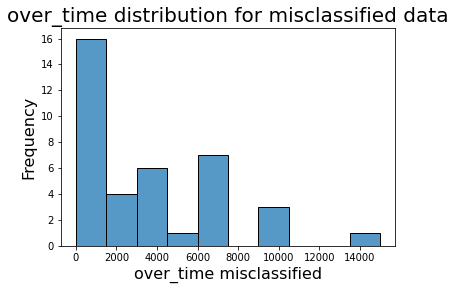

In [61]:
sns.histplot(df_mis['over_time'], bins=10, binrange=(0, 15000))

# add a title to the plot
plt.title('over_time distribution for misclassified data', fontsize=20)
plt.xlabel('over_time misclassified', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

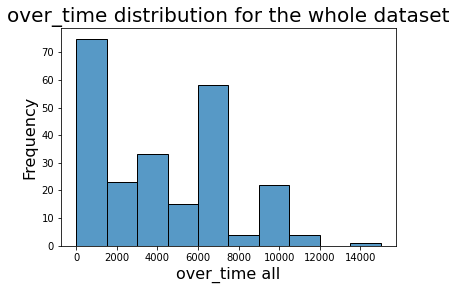

In [62]:
sns.histplot(df_val['over_time'], bins=10, binrange=(0, 15000))

# tite and label
plt.title('over_time distribution for the whole dataset', fontsize=20)
plt.xlabel('over_time all', fontsize=16)
plt.ylabel('Frequency', fontsize=16)


Text(0, 0.5, 'Frequency')

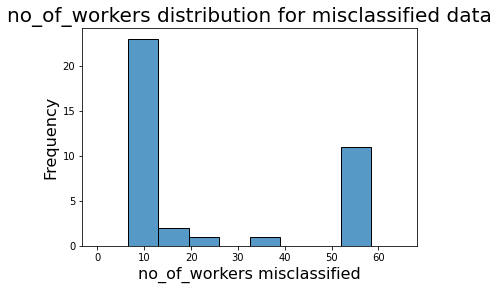

In [63]:
sns.histplot(df_mis['no_of_workers'], bins=10, binrange=(0, 65))

# add a title to the plot
plt.title('no_of_workers distribution for misclassified data', fontsize=20)
plt.xlabel('no_of_workers misclassified', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

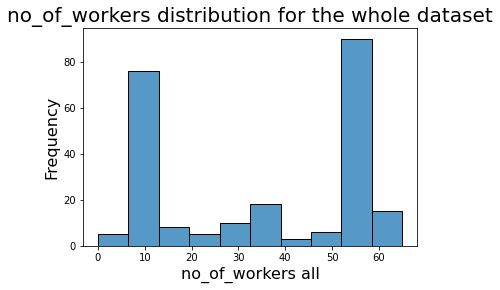

In [64]:
sns.histplot(df_val['no_of_workers'], bins=10, binrange=(0, 65))

# title and label
plt.title('no_of_workers distribution for the whole dataset', fontsize=20)
plt.xlabel('no_of_workers all', fontsize=16)
plt.ylabel('Frequency', fontsize=16)


no_of_workers seems to be little different, but not that different.

In [67]:
# type 1 error or false positive rate
def false_positive_rate(y_true, y_pred):
    return np.mean(y_pred[y_true == 0])

# type 2 error or false negative rate
def false_negative_rate(y_true, y_pred):
    return np.mean(y_pred[y_true == 1])

